# Qibolab v0.1.9 1Q emulator demo for QuTiP engine

Results updated on: 08 September 2024

## Setting up and using the emulator platform

The emulator is instantiated like any other device platform in Qibolab, by first adding the path to the emulator runcard to the `QIBOLAB_PLATFORMS` environment variable and then using `qibolab.create_platform`. In this tutorial, we will be using the test emulator `default_q0` that can be found in ``/qibolab/tests/emulators/``:

In [1]:
# add directory of emulator platform to QIBOLAB_PLATFORMS environment variable
import pathlib, os
emulator_path = pathlib.Path(os.path.abspath('')).parent/'tests/emulators/'
os.environ["QIBOLAB_PLATFORMS"] = emulator_path.as_posix() 

# create emulator platform as per any other device platform
from qibolab import create_platform
emulator_platform = create_platform("default_q0")

[Qibo 0.2.6|INFO|2024-09-08 17:18:42]: Loading platform default_q0
INFO:qibo.config:Loading platform default_q0


{'model_name': 'general_no_coupler_model', 'topology': [], 'qubits_list': ['0'], 'nlevels_q': [3], 'couplers_list': [], 'nlevels_c': [], 'drift': {'one_body': [(31.982463978551852, 'O_0', ['0']), (-1.0559615637828141, 'O_0 * O_0 - O_0', ['0'])], 'two_body': []}, 'drive': {'D-0': [(2.092300707290802, 'X_0', ['0'])]}, 'flux': {'F-0': [(6.283185307179586, 'O_0', ['0'])]}, 'flux_params': {}, 'dissipation': {'t1': [(0.005955398137529539, 'sp01_0', ['0'])], 't2': [(0.0054236727921428375, 'Z01_0', ['0'])]}, 'method': 'master_equation', 'readout_error': {'0': [0.01, 0.02]}, 'platform_to_simulator_channels': {'drive-0': 'D-0', 'readout-0': 'R-0', 'flux-0': 'F-0'}}


Similarly, the emulator plays pulse sequences in the same way as any other device platforms. In this tutorial, we will play a simple RX pulse followed by a readout pulse as defined in the runcard on the 'default_q0' single-qubit emulator that we have just initialized:

In [2]:
from qibolab.pulses import PulseSequence

# Extract preset pulses from runcard
pulse_x0 = emulator_platform.create_RX_pulse(qubit=0, start=0)
pulse_r0 = emulator_platform.create_qubit_readout_pulse(qubit=0, start=int(pulse_x0.duration + 5))

# Add pulses to PulseSequence
sequence = PulseSequence()
sequence.add(pulse_x0)
sequence.add(pulse_r0)

from qibolab.execution_parameters import ExecutionParameters

# Execute the pulse sequence and save the output
options = ExecutionParameters(nshots=1000)
results = emulator_platform.execute_pulse_sequence(sequence, options=options)

[Qibo 0.2.6|INFO|2024-09-08 17:18:42]: Minimal execution time (sequence): 0.30500777777777777
INFO:qibo.config:Minimal execution time (sequence): 0.30500777777777777


 Total run time:   1.24s*] Elapsed 1.24s / Remaining 00:00:00:00[*********71%****       ] Elapsed 0.78s / Remaining 00:00:00:00[*********74%*****      ] Elapsed 0.85s / Remaining 00:00:00:00[*********74%*****      ] Elapsed 0.88s / Remaining 00:00:00:00[*********77%******     ] Elapsed 0.95s / Remaining 00:00:00:00


## Pulse simulator and simulation engine

The only instrument used by the emulator is the :class:`qibolab.instruments.emulator.pulse_simulator.PulseSimulator`

In [3]:
pulse_simulator = emulator_platform.instruments['pulse_simulator']

The information from the runcard used to initialized the `PulseSimulator` can be found under `'instruments'`, and is further grouped under `'model_params'` and `'simulations_config'`. 

In [4]:
from qibolab.serialize import load_runcard

load_runcard(emulator_path/"default_q0")['instruments']

{'pulse_simulator': {'model_params': {'model_name': 'general_no_coupler_model',
   'topology': [],
   'nqubits': 1,
   'ncouplers': 0,
   'qubits_list': ['0'],
   'couplers_list': [],
   'nlevels_q': [3],
   'nlevels_c': [],
   'readout_error': {'0': [0.01, 0.02]},
   'drive_freq': {'0': 5.090167234445013},
   'T1': {'0': 88578.48970762537},
   'T2': {'0': 106797.94866226273},
   'max_lo_freq': {'0': 5.090167234445013},
   'rabi_freq': {'0': 0.333},
   'anharmonicity': {'0': -0.3361230051821652},
   'coupling_strength': {}},
  'simulation_config': {'simulation_engine_name': 'Qutip',
   'sampling_rate': 4.5,
   'sim_sampling_boost': 10,
   'runcard_duration_in_dt_units': False,
   'instant_measurement': True,
   'simulate_dissipation': True,
   'output_state_history': True},
  'sim_opts': None,
  'bounds': {'waveforms': 1, 'readout': 1, 'instructions': 1}}}

As indicated from 'model_params', this emulator simulates a single qubit as a 3-level quantum system with no couplers. All frequencies given are in units of GHz and all times in ns.

The PulseSimulator contains a `simulation_engine`, which in turn contains methods to simulate the dynamics of the pulse-device system, as well as process the results, using a specific quantum dynamics simulation library, which in this case is `QuTiP`:

In [5]:
simulation_engine = pulse_simulator.simulation_engine

To help visualize the model, we can use the `print_hamiltonian` function from `qibolab_visualization.emulator`:

In [6]:
from qibolab_visualization.emulator import print_hamiltonian
print_hamiltonian(simulation_engine.model_config)

Dictionary


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



---------------------
One-body drift terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Two-body drift terms:
---------------------
None
---------------------
One-body drive terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Dissipative terms:
---------------------
>> t1 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

>> t2 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------


## Simulation results

The simulation results generated by the simulation engine are returned together with the usual outputs of `execute_pulse_sequence` for device platforms and are grouped under 'simulation'. 

Let us retrieve the simulation results obtained previously:

In [7]:
simulation_results = results['simulation']
simulation_results.keys()

dict_keys(['sequence_duration', 'simulation_dt', 'simulation_time', 'output_states'])

The time taken to complete the simulation is:

In [8]:
simulation_results['simulation_time']

1.246244167

In addition, one can generate the list of discretized times used in the simulation:

In [9]:
import numpy as np
sequence_duration = simulation_results['sequence_duration']
simulation_dt = simulation_results['simulation_dt']
sim_time_list = np.linspace(0,sequence_duration,num=int(sequence_duration/simulation_dt)+1)

When 'output_state_history' in `'simulation_config'` is set to 'True', the corresponding device quantum states obtained from simulation at each of these times are stored in 'output_states' as objects native to the simulation engine library. In this case, these are :class:`qutip.Qobj`. As an example, we see that the initial state is indeed the density matrix for a 3 level system corresponding to $\ket{0}$:

In [10]:
simulated_states = simulation_results['output_states']
simulated_states[0]

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

One can call the `compute_overlaps` method in the simulation engine to compute the overlaps of the state with the different computational basis states for the entire simulation history. We can then visualize this with the plot_overlaps function from `qibolab_visualization.emulator`:

Overlap of final state with basis states:
[0] 0.0016351326811553345
[1] 0.9982829949142029
[2] 8.187240463464329e-05


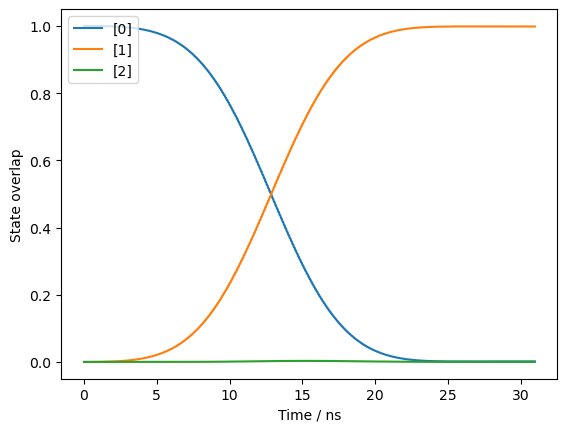

In [11]:
overlaps = simulation_engine.compute_overlaps(simulated_states)

from qibolab_visualization.emulator import plot_overlaps
plot_overlaps(overlaps,sim_time_list,time_label='Time / ns');

## Sampling and applying readout noise

By default, the 'readout_error' from the `'model_params'` dictionary is applied when generating the samples from simulation without noise:

In [12]:
samples = results[0].samples
samples[:20].tolist(), np.sum(samples)

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 984)

Samples can be obtained from the final state of the simulation without applying readout error manually by the `get_samples` function:

In [13]:
final_state = simulated_states[-1]

from qibolab.instruments.emulator.pulse_simulator import get_samples
ro_qubit_list = [pulse_r0.qubit]
ro_reduced_dm, rdm_qubit_list = pulse_simulator.simulation_engine.qobj_to_reduced_dm(final_state, ro_qubit_list)
noiseless_samples = get_samples(1000, ro_reduced_dm, rdm_qubit_list, pulse_simulator.simulation_engine.qid_nlevels_map)

noiseless_samples[0][:20], np.sum(noiseless_samples[0])

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 997)

The `readout_error` can be applied subsequently as well with the `apply_readout_noise` function:

In [14]:
from qibolab.instruments.emulator.pulse_simulator import apply_readout_noise

readout_error = {0: [0.1, 0.1], 1: [0.1, 0.1]}
noisy_samples = apply_readout_noise(noiseless_samples, readout_error)
noisy_samples[0][:20], np.sum(noisy_samples[0])

([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], 895)

## Returning only the final state of simulations

In some cases, the entire history of the simulated states is not needed. One can save memory by setting `'output_state_history' = 'False'`in `'simulations_config'`. This is useful for instance when running sweepers:

In [15]:
from qibolab.sweeper import Sweeper, Parameter

parameter = Parameter.duration
parameter2 = Parameter.amplitude
parameter_range = np.linspace(pulse_x0.duration*.5, pulse_x0.duration*1.0, num=2)
parameter2_range = np.linspace(pulse_x0.amplitude*.95, pulse_x0.amplitude*1.05, num=3)
sweeper = Sweeper(parameter, parameter_range, [pulse_x0])
sweeper2 = Sweeper(parameter2, parameter2_range, [pulse_x0])

In [16]:
# output only final state
emulator_platform.instruments['pulse_simulator'].output_state_history = False
sweep_results = emulator_platform.sweep(sequence, ExecutionParameters(), sweeper, sweeper2)

[Qibo 0.2.6|INFO|2024-09-08 17:18:44]: Minimal execution time (sweep): 7.4958711466666665
INFO:qibo.config:Minimal execution time (sweep): 7.4958711466666665


 Total run time:   0.85s*] Elapsed 0.84s / Remaining 00:00:00:00
 Total run time:   0.97s*] Elapsed 0.97s / Remaining 00:00:00:00[*********81%*******    ] Elapsed 0.86s / Remaining 00:00:00:00
 Total run time:   1.05s*] Elapsed 1.05s / Remaining 00:00:00:00[*********49%           ] Elapsed 0.51s / Remaining 00:00:00:00
 Total run time:   1.68s*] Elapsed 1.68s / Remaining 00:00:00:00[*****    20%           ] Elapsed 0.52s / Remaining 00:00:00:02
 Total run time:   1.21s*] Elapsed 1.21s / Remaining 00:00:00:00[*********55%*          ] Elapsed 0.78s / Remaining 00:00:00:00
 Total run time:   1.02s*] Elapsed 1.02s / Remaining 00:00:00:00


To help visualize the simulation results, we can once again look at its overlap with the basis states of the system. We use `make_array_index_list` function to generate a list of all possible index combinations of an array with arbitrary shape, in this case corresponding to all possible combinations of different sweeper parameters:

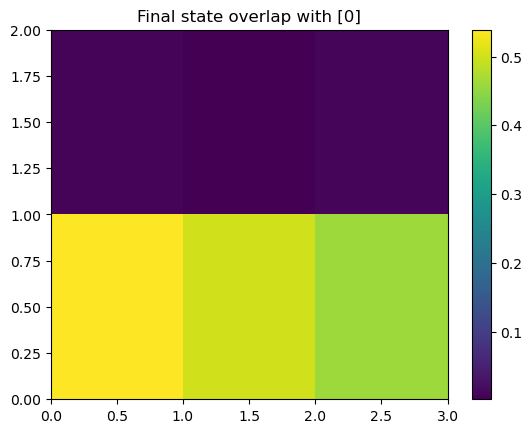

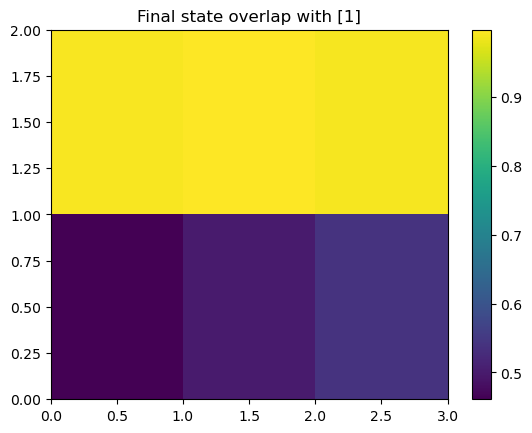

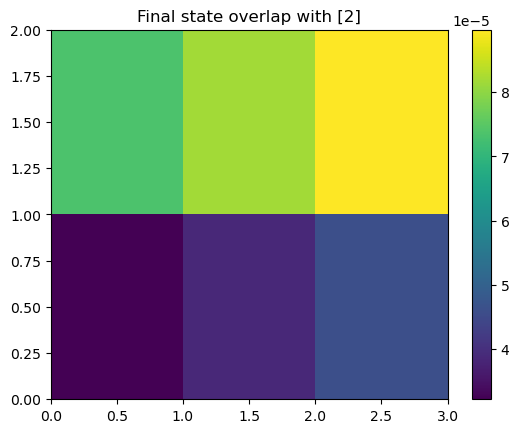

In [17]:
from qibolab.instruments.emulator.pulse_simulator import make_array_index_list

final_states_array = sweep_results['simulation']['output_states']
shape = final_states_array.shape
index_list = make_array_index_list(shape)
overlaps = {}
for index in index_list:
    pulse_simulator.merge_sweep_results(overlaps, simulation_engine.compute_overlaps(final_states_array[tuple(index)]))

import matplotlib.pyplot as plt
for label in overlaps.keys():
    plt.figure()
    plt.pcolormesh(np.array(overlaps[label]).reshape(shape))
    plt.colorbar()
    plt.title(f'Final state overlap with {label}')
    plt.show()

## Flux-pulse-based 2-qubit gates

In the following, we demonstrate the emulator's support for flux-pulse-based two-qubit gates by using the two-qubit test emulator `default_q01_flux` that can be found in ``/qibolab/tests/emulators/``. For this purpose, we will simulate each qubit as a two-level system:

In [18]:
# create two-qubit emulator platform as per any other device platform

emulator_platform = create_platform("default_q01_flux")
simulation_engine = emulator_platform.instruments['pulse_simulator'].simulation_engine

[Qibo 0.2.6|INFO|2024-09-08 17:18:51]: Loading platform default_q01_flux
INFO:qibo.config:Loading platform default_q01_flux


{'model_name': 'general_no_coupler_model', 'topology': [[0, 1]], 'qubits_list': ['0', '1'], 'nlevels_q': [2, 2], 'couplers_list': [], 'nlevels_c': [], 'drift': {'one_body': [(28.274333882308138, 'O_0', ['0']), (-0.9424777960769379, 'O_0 * O_0 - O_0', ['0']), (27.01769682087222, 'O_1', ['1']), (-0.9738937226128359, 'O_1 * O_1 - O_1', ['1'])], 'two_body': [(0.03769911184307752, 'bdag_1 ^ b_0 + b_1 ^ bdag_0', ['1', '0'])]}, 'drive': {'D-0': [(2.098583892597982, 'X_0', ['0'])], 'D-1': [(2.098583892597982, 'X_1', ['1'])]}, 'flux': {'F-0': [(6.283185307179586, 'O_0', ['0'])], 'F-1': [(6.283185307179586, 'O_1', ['1'])]}, 'flux_params': {'0': {'flux_quanta': 0.3183098861837907, 'max_frequency': 4.5, 'current_frequency': 4.5}, '1': {'flux_quanta': 0.3183098861837907, 'max_frequency': 4.3, 'current_frequency': 4.3}}, 'dissipation': {'t1': [(0.0, 'sp01_0', ['0']), (0.0, 'sp01_1', ['1'])], 't2': [(0.0, 'Z01_0', ['0']), (0.0, 'Z01_1', ['1'])]}, 'method': 'master_equation', 'readout_error': {'0': [0

In this demonstration, we first apply an RX pulse on qubit 0, but in addition we also apply an iSWAP pulse on both qubits right after before finally applying readout pulses on both qubits:

In [19]:
from qibolab.pulses import FluxPulse

# Extract preset pulses from runcard
duration = 0
pulse_x0 = emulator_platform.create_RX_pulse(qubit=0, start=0)
duration += pulse_x0.duration
pulse_iswap01 = emulator_platform.create_iSWAP_pulse_sequence(qubits=[0,1],start=int(duration))[0]
duration += pulse_iswap01.duration
pulse_r0 = emulator_platform.create_qubit_readout_pulse(qubit=0, start=int(duration))
pulse_r1 = emulator_platform.create_qubit_readout_pulse(qubit=1, start=int(duration))

# Add pulses to PulseSequence
sequence = PulseSequence()
sequence.add(pulse_x0)
sequence.add(pulse_iswap01)
sequence.add(pulse_r0)
sequence.add(pulse_r1)

# Execute the pulse sequence and save the output
results = emulator_platform.execute_pulse_sequence(sequence, options=options)

[Qibo 0.2.6|INFO|2024-09-08 17:18:51]: Minimal execution time (sequence): 0.32246600000000003
INFO:qibo.config:Minimal execution time (sequence): 0.32246600000000003


 Total run time:   3.68s*] Elapsed 3.68s / Remaining 00:00:00:00[*********84%*******    ] Elapsed 3.24s / Remaining 00:00:00:00[*********85%********   ] Elapsed 3.25s / Remaining 00:00:00:00[*********99%***********] Elapsed 3.64s / Remaining 00:00:00:00[*********99%***********] Elapsed 3.65s / Remaining 00:00:00:00


Following the same steps as before, we extract the simulation results and plot the overlap of the two-qubit state with the various computational basis states as it evolves in time under the above pulse sequence:

Overlap of final state with basis states:
[0, 0] 2.3806684324678472e-05
[0, 1] 0.9980132409681193
[1, 0] 0.0019625117159143535
[1, 1] 4.4063163784844247e-07


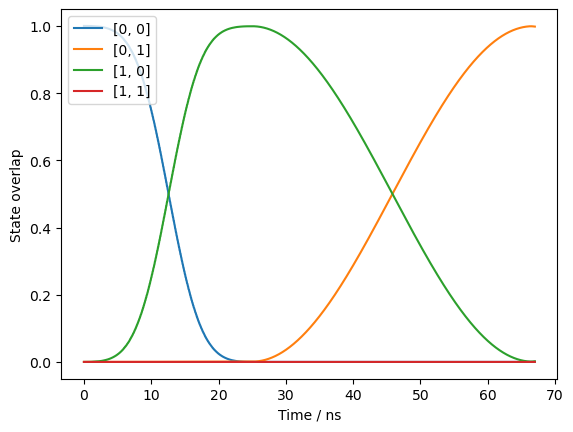

In [20]:
simulation_results = results['simulation']
simulated_states = simulation_results['output_states']

sequence_duration = simulation_results['sequence_duration']
simulation_dt = simulation_results['simulation_dt']
sim_time_list = np.linspace(0,sequence_duration,num=int(sequence_duration/simulation_dt)+1)

overlaps = simulation_engine.compute_overlaps(simulated_states)
plot_overlaps(overlaps,sim_time_list,time_label='Time / ns');

## iSWAP sweep for 2-qubit 1-coupler system (temporary)

In [22]:
# create two-qubit one-coupler emulator platform as per any other device platform

emulator_platform = create_platform("default_q01c0_flux")
pulse_simulator = emulator_platform.instruments['pulse_simulator']
simulation_engine = pulse_simulator.simulation_engine

[Qibo 0.2.6|INFO|2024-09-08 17:21:21]: Loading platform default_q01c0_flux
INFO:qibo.config:Loading platform default_q01c0_flux


{'model_name': 'general_coupler_model', 'topology': [[0, 1]], 'qubits_list': ['0', '1'], 'nlevels_q': [2, 2], 'couplers_list': ['c0'], 'nlevels_c': [2], 'drift': {'one_body': [(28.616767481549424, 'O_0', ['0']), (-0.9424777960769379, 'O_0 * O_0 - O_0', ['0']), (29.05225505519004, 'O_1', ['1']), (-0.9738937226128359, 'O_1 * O_1 - O_1', ['1']), (40.21238596594935, 'O_c0', ['c0']), (0.0, 'O_c0 * O_c0 - O_c0', ['c0'])], 'two_body': [(0.04146902302738527, 'bdag_1 ^ b_0 + b_1 ^ bdag_0', ['1', '0']), (0.5372123437638546, 'bdag_1 ^ b_c0 + b_1 ^ bdag_c0', ['1', 'c0']), (0.5636017220540089, 'bdag_0 ^ b_c0 + b_0 ^ bdag_c0', ['0', 'c0'])]}, 'drive': {'D-0': [(2.098583892597982, 'X_0', ['0'])], 'D-1': [(2.098583892597982, 'X_1', ['1'])], 'D-c0': [(0.0, 'X_c0', ['c0'])]}, 'flux': {'F-0': [(6.283185307179586, 'O_0', ['0'])], 'F-1': [(6.283185307179586, 'O_1', ['1'])], 'F-c0': [(6.283185307179586, 'O_c0', ['c0'])]}, 'flux_params': {'0': {'flux_quanta': 0.3183098861837907, 'max_frequency': 4.5545, 'cur

In [23]:
from qibolab.serialize import load_runcard
from qibolab.instruments.emulator.models.methods import flux_pulse_amp_from_detuning

emu_runcard = load_runcard(emulator_path/"default_q01c0_flux")
emu_model_params = emu_runcard['instruments']['pulse_simulator']['model_params']
w0 = emu_model_params['max_lo_freq']['0']
w1 =emu_model_params['max_lo_freq']['1']
wc = emu_model_params['max_lo_freq']['c0']
fluxquanta1 = emu_model_params['flux_quanta']['1']
fluxquantac = emu_model_params['flux_quanta']['c0']

q1fluxH_coeff = w0 - w1
q1flux_amp = flux_pulse_amp_from_detuning(q1fluxH_coeff, fluxquanta1, w1, w1)

import numpy as np

anglelist = np.linspace(-np.pi/2, np.pi/2, 200)
c_flux_amp_list = anglelist*fluxquantac

In [25]:
from qibolab.pulses import PulseSequence, FluxPulse, CouplerFluxPulse
from qibolab.pulses import Rectangular

t = 200

q1_flux_pulse = FluxPulse(
    start=0, 
    duration=t,
    amplitude=q1flux_amp, 
    shape=Rectangular(), 
    channel='flux-1',
    qubit=1)

c0_flux_pulse = CouplerFluxPulse(
    start=0, 
    duration=t,
    amplitude=c_flux_amp_list[-1], 
    shape=Rectangular(), 
    channel='flux-c0',
    qubit=0)

# Extract readout pulses from runcard
pulse_r0 = emulator_platform.create_qubit_readout_pulse(qubit=0, start=t)
#pulse_r1 = emulator_platform.create_qubit_readout_pulse(qubit=1, start=t)

# Add pulses to PulseSequence
sequence = PulseSequence()
sequence.add(q1_flux_pulse)
sequence.add(c0_flux_pulse)
sequence.add(pulse_r0)
#sequence.add(pulse_r1)

# Set specific initial state
simulation_engine.psi0 = simulation_engine.state_from_basis_vector([1,0])

In [26]:
from qibolab.sweeper import Sweeper, Parameter

parameter = Parameter.amplitude
parameter_range = c_flux_amp_list
sweeper = Sweeper(parameter, parameter_range, [c0_flux_pulse])

sweep_results = emulator_platform.sweep(sequence, ExecutionParameters(), sweeper)

[Qibo 0.2.6|INFO|2024-09-08 17:21:25]: Minimal execution time (sweep): 264.27392000000003
INFO:qibo.config:Minimal execution time (sweep): 264.27392000000003


 Total run time:   2.21s*] Elapsed 2.21s / Remaining 00:00:00:00[*********70%****       ] Elapsed 1.33s / Remaining 00:00:00:00
 Total run time:   1.62s*] Elapsed 1.62s / Remaining 00:00:00:00
 Total run time:   1.63s*] Elapsed 1.63s / Remaining 00:00:00:00[*********92%*********  ] Elapsed 1.53s / Remaining 00:00:00:00
 Total run time:   0.86s*] Elapsed 0.86s / Remaining 00:00:00:00[*********62%**         ] Elapsed 0.54s / Remaining 00:00:00:00
 Total run time:   0.85s*] Elapsed 0.85s / Remaining 00:00:00:00
 Total run time:   0.76s*] Elapsed 0.76s / Remaining 00:00:00:00
 Total run time:   0.84s*] Elapsed 0.84s / Remaining 00:00:00:00
 Total run time:   1.28s*] Elapsed 1.28s / Remaining 00:00:00:00[******   25%           ] Elapsed 0.20s / Remaining 00:00:00:00
 Total run time:   0.67s*] Elapsed 0.67s / Remaining 00:00:00:00
 Total run time:   0.74s*] Elapsed 0.74s / Remaining 00:00:00:00
 Total run time:   0.80s*] Elapsed 0.80s / Remaining 00:00:00:00[**        7%           ] Elapsed 

In [27]:
from qibolab.instruments.emulator.pulse_simulator import make_array_index_list

final_states_array = sweep_results['simulation']['output_states']
shape = final_states_array.shape
index_list = make_array_index_list(shape)
overlaps = {}
for index in index_list:
    pulse_simulator.merge_sweep_results(overlaps, simulation_engine.compute_overlaps(final_states_array[tuple(index)]))

new_shape = [shape[0],len(final_states_array[0])]
res_array = -np.array(overlaps['[1, 0, 0]']).reshape(*new_shape) + np.array(overlaps['[0, 1, 0]']).reshape(*new_shape)

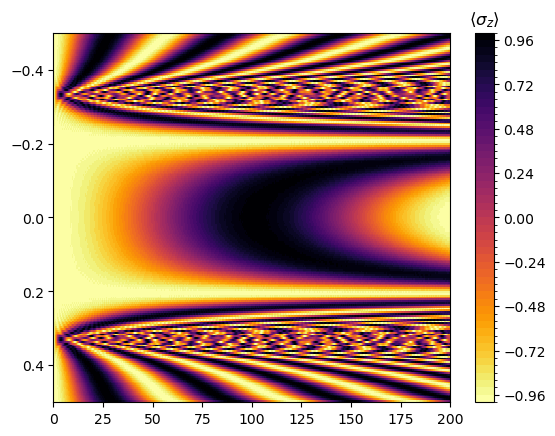

In [36]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

plt.figure()
levels = MaxNLocator(nbins=50).tick_values(-1, 1)
cmap = plt.get_cmap('inferno_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = plt.imshow(res_array, cmap, norm, extent=(0, t, anglelist[-1]/np.pi, anglelist[0]/np.pi), aspect="auto", origin="upper", interpolation='None')
clb = plt.colorbar()
clb.ax.set_title(r"$\langle\sigma_z\rangle$")
plt.show()

## --- Version information for major packages used in the current Qibolab emulator example ---

In [29]:
%load_ext watermark

In [30]:
%watermark -v -p qibolab,qibo,qutip,matplotlib,numpy,scipy

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.15.0

qibolab   : 0.1.9
qibo      : 0.2.6
qutip     : 4.7.5
matplotlib: 3.8.0
numpy     : 1.26.4
scipy     : 1.12.0

